In [1]:
import tensorflow as tf
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from config import Config
import scipy
import skimage.color
import skimage.io
import skimage.transform
import sys
import os
import logging
import math
import random
import numpy as np
import tensorflow as tf
import scipy
import skimage.color
import skimage.io
import skimage.transform
import urllib.request
import shutil
import warnings

In [2]:
config = Config()

In [3]:

def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)

def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes


backbone_shapes = compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                                      config.RPN_ANCHOR_RATIOS,
                                                      backbone_shapes,
                                                      config.BACKBONE_STRIDES,
                                                      config.RPN_ANCHOR_STRIDE)
batch_size = 1

In [4]:
def build_rpn_targets(image_shape, anchors, gt_class_ids, gt_boxes):
    """Given the anchors and GT boxes, compute overlaps and identify positive
    anchors and deltas to refine them to match their corresponding GT boxes.

    anchors: [num_anchors, (y1, x1, y2, x2)]
    gt_class_ids: [num_gt_boxes] Integer class IDs.
    gt_boxes: [num_gt_boxes, (y1, x1, y2, x2)]

    Returns:
    rpn_match: [N] (int32) matches between anchors and GT boxes.
               1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_bbox: [N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    """
    # RPN Match: 1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_match = np.zeros([anchors.shape[0]], dtype=np.int32)
    # RPN bounding boxes: [max anchors per image, (dy, dx, log(dh), log(dw))]
    rpn_bbox = np.zeros((config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4))

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = np.where(gt_class_ids < 0)[0]
    if crowd_ix.shape[0] > 0:
        # Filter out crowds from ground truth class IDs and boxes
        non_crowd_ix = np.where(gt_class_ids > 0)[0]
        crowd_boxes = gt_boxes[crowd_ix]
        gt_class_ids = gt_class_ids[non_crowd_ix]
        gt_boxes = gt_boxes[non_crowd_ix]
        # Compute overlaps with crowd boxes [anchors, crowds]
        crowd_overlaps = compute_overlaps(anchors, crowd_boxes)
        crowd_iou_max = np.amax(crowd_overlaps, axis=1)
        no_crowd_bool = (crowd_iou_max < 0.001)
    else:
        # All anchors don't intersect a crowd
        no_crowd_bool = np.ones([anchors.shape[0]], dtype=bool)

    # Compute overlaps [num_anchors, num_gt_boxes]
    overlaps = compute_overlaps(anchors, gt_boxes)

    # Match anchors to GT Boxes
    # If an anchor overlaps a GT box with IoU >= 0.7 then it's positive.
    # If an anchor overlaps a GT box with IoU < 0.3 then it's negative.
    # Neutral anchors are those that don't match the conditions above,
    # and they don't influence the loss function.
    # However, don't keep any GT box unmatched (rare, but happens). Instead,
    # match it to the closest anchor (even if its max IoU is < 0.3).
    #
    # 1. Set negative anchors first. They get overwritten below if a GT box is
    # matched to them. Skip boxes in crowd areas.
    anchor_iou_argmax = np.argmax(overlaps, axis=1)
    anchor_iou_max = overlaps[np.arange(overlaps.shape[0]), anchor_iou_argmax]
    rpn_match[(anchor_iou_max < 0.3) & (no_crowd_bool)] = -1
    # 2. Set an anchor for each GT box (regardless of IoU value).
    # If multiple anchors have the same IoU match all of them
    gt_iou_argmax = np.argwhere(overlaps == np.max(overlaps, axis=0))[:,0]
    rpn_match[gt_iou_argmax] = 1
    # 3. Set anchors with high overlap as positive.
    rpn_match[anchor_iou_max >= 0.7] = 1

    # Subsample to balance positive and negative anchors
    # Don't let positives be more than half the anchors
    ids = np.where(rpn_match == 1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE // 2)
    if extra > 0:
        # Reset the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0
    # Same for negative proposals
    ids = np.where(rpn_match == -1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE -
                        np.sum(rpn_match == 1))
    if extra > 0:
        # Rest the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0

    # For positive anchors, compute shift and scale needed to transform them
    # to match the corresponding GT boxes.
    ids = np.where(rpn_match == 1)[0]
    ix = 0  # index into rpn_bbox
    # TODO: use box_refinement() rather than duplicating the code here
    for i, a in zip(ids, anchors[ids]):
        # Closest gt box (it might have IoU < 0.7)
        gt = gt_boxes[anchor_iou_argmax[i]]

        # Convert coordinates to center plus width/height.
        # GT Box
        gt_h = gt[2] - gt[0]
        gt_w = gt[3] - gt[1]
        gt_center_y = gt[0] + 0.5 * gt_h
        gt_center_x = gt[1] + 0.5 * gt_w
        # Anchor
        a_h = a[2] - a[0]
        a_w = a[3] - a[1]
        a_center_y = a[0] + 0.5 * a_h
        a_center_x = a[1] + 0.5 * a_w

        # Compute the bbox refinement that the RPN should predict.
        rpn_bbox[ix] = [
            (gt_center_y - a_center_y) / a_h,
            (gt_center_x - a_center_x) / a_w,
            np.log(gt_h / a_h),
            np.log(gt_w / a_w),
        ]
        # Normalize
        rpn_bbox[ix] /= config.RPN_BBOX_STD_DEV
        ix += 1

    return rpn_match, rpn_bbox


def compute_overlaps(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].

    For better performance, pass the largest set first and the smaller second.
    """
    # Areas of anchors and GT boxes
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute overlaps to generate matrix [boxes1 count, boxes2 count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps

def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.

    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou

In [5]:
def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().

    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
#     if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
#         # New in 0.14: anti_aliasing. Default it to False for backward
#         # compatibility with skimage 0.13.
    return skimage.transform.resize(
        image, output_shape,
        order=order, mode=mode, cval=cval, clip=clip,
        preserve_range=preserve_range, anti_aliasing=anti_aliasing,
        anti_aliasing_sigma=anti_aliasing_sigma)
#     else:
#         return skimage.transform.resize(
#             image, output_shape,
#             order=order, mode=mode, cval=cval, clip=clip,
#             preserve_range=preserve_range)


In [6]:
num_classes = 80

In [7]:
def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = resize(image, (round(h * scale), round(w * scale)),
                       preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop

def resize_mask(mask, scale, padding, crop=None):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.

    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    if crop is not None:
        y, x, h, w = crop
        mask = mask[y:y + h, x:x + w]
    else:
        mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask

def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

In [8]:
def pad_resize(image, height, width, h_c, w_c):
        """Summary
        
        Args:
            image (TYPE): Description
            height (TYPE): Description
            width (TYPE): Description
            scale (TYPE): Description
        
        Returns:
            numpy nd.array: Description
        """
        padded_image = np.zeros(shape=(height.astype(int), width.astype(int),3), dtype=image.dtype)
        h,w,_ =  image.shape
        padded_image[:h,:w,:] = image
#         print(padded_image.shape)
#         print(h_c, w_c)
#         resized_image = cv2.resize(padded_image, None).astype(tf.keras.backend.floatx())
        return padded_image


def get_mask(mask, height, width, label):
    mask = np.frombuffer(mask, dtype = 'bool')
    mask = mask.reshape((height, width, len(label)))
#     print(mask.shape)
    return mask

@tf.function
def decode_pad_resize(image_string, pad_height, pad_width, height, width):
  """Summary

  Args:
      image_string (TYPE): Description
      pad_height (TYPE): Description
      pad_width (TYPE): Description
      scale (TYPE): Description

  Returns:
      tf.tensor: Description
  """
  image = tf.image.decode_jpeg(image_string)
#   print(image.shape, height, width)
#   print('haha')
  image = tf.numpy_function(pad_resize, [image, pad_height, pad_width, height, width], Tout=tf.uint8)
  #image.set_shape([None, None, 3])
  return image



def load_image_gt(image, mask, label, fid):
#     print(image.shape, mask.shape, label)
    original_shape = image.shape
    image, window, scale, padding, crop = resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)
    
    mask = resize_mask(mask, scale, padding, crop)
#     print('after conversion ' + str(image.shape) + ' ' +str(mask.shape))
    _idx = np.sum(mask, axis=(0, 1)) > 0
    mask = mask[:, :, _idx]
    class_ids = label[_idx]
    bbox = extract_bboxes(mask)
#     print(bbox)
    active_class_ids = np.ones([num_classes], dtype=np.int32)
    image_meta = compose_image_meta(fid, original_shape, image.shape,
                                    window, scale, active_class_ids)
#     print(image_meta)
#     print(type(image), type(image_meta), type(class_ids), type(bbox), type(mask))
#     return True
    return image, image_meta, class_ids, bbox, mask

def rpn_t(image, anchors, gt_class_ids, gt_boxes):
    rpn_match, rpn_bbox = build_rpn_targets(image.shape, anchors,
                                                    gt_class_ids, gt_boxes)
#     print('rpn shapes -> ' + str(np.unique(rpn_match)), str(np.unique(rpn_bbox)))
    return rpn_match, rpn_bbox

In [9]:
def mold_image(images):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL

def ret_final(image_meta, rpn_match, rpn_bbox, image, gt_class_ids, gt_boxes, gt_masks):
    batch_image_meta = np.zeros(
                    (batch_size,) + image_meta.shape, dtype=image_meta.dtype)
    batch_rpn_match = np.zeros(
        [batch_size, anchors.shape[0], 1], dtype=rpn_match.dtype)
    batch_rpn_bbox = np.zeros(
        [batch_size, config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
    batch_images = np.zeros(
        (batch_size,) + image.shape, dtype=np.float32)
    batch_gt_class_ids = np.zeros(
        (batch_size, config.MAX_GT_INSTANCES), dtype=np.int32)
    batch_gt_boxes = np.zeros(
        (batch_size, config.MAX_GT_INSTANCES, 4), dtype=np.int32)
    batch_gt_masks = np.zeros(
        (batch_size, gt_masks.shape[0], gt_masks.shape[1],
         config.MAX_GT_INSTANCES), dtype=gt_masks.dtype)
    if gt_boxes.shape[0] > config.MAX_GT_INSTANCES:
        ids = np.random.choice(
            np.arange(gt_boxes.shape[0]), config.MAX_GT_INSTANCES, replace=False)
        gt_class_ids = gt_class_ids[ids]
        gt_boxes = gt_boxes[ids]
        gt_masks = gt_masks[:, :, ids]
    b = 0
    batch_image_meta[b] = image_meta
    batch_rpn_match[b] = rpn_match[:, np.newaxis]
    batch_rpn_bbox[b] = rpn_bbox
    batch_images[b] = mold_image(image.astype(np.float32))
    batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
    batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
    batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
    return batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, batch_gt_boxes, batch_gt_masks

In [10]:
def _parse_function(serialized):
    """Summary

    Args:
        serialized (TYPE): Description

    Returns:
        TYPE: Description
    """
    features = {
      'image/height': tf.io.FixedLenFeature([], tf.int64),
      'image/width': tf.io.FixedLenFeature([], tf.int64),
      'image/encoded': tf.io.FixedLenFeature([],tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.keras.backend.floatx()),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.keras.backend.floatx()),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.keras.backend.floatx()),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.keras.backend.floatx()),
      'image/f_id': tf.io.FixedLenFeature([], tf.int64),
      'image/object/class/label':tf.io.VarLenFeature(tf.int64),
      'image/object/mask': tf.io.FixedLenFeature([],tf.string)
    }


    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
    fid = tf.cast(tf.keras.backend.max(parsed_example['image/f_id']), tf.int32)
    max_height = tf.cast(tf.keras.backend.max(parsed_example['image/height']), tf.int32)
    max_width = tf.cast(tf.keras.backend.max(parsed_example['image/width']), tf.int32)
    image_batch = tf.image.decode_jpeg(parsed_example['image/encoded'])

    xmin = tf.sparse.to_dense(parsed_example['image/object/bbox/xmin'], default_value=-1)
    xmax = tf.sparse.to_dense(parsed_example['image/object/bbox/xmax'], default_value=-1)
    ymin = tf.sparse.to_dense(parsed_example['image/object/bbox/ymin'], default_value=-1)
    ymax = tf.sparse.to_dense(parsed_example['image/object/bbox/ymax'], default_value=-1)
    label = tf.sparse.to_dense(parsed_example['image/object/class/label'], default_value=-1)
#     image_batch = tf.numpy_function(try_f, [image_batch, max_height, max_width, xmin, xmax, ymin, ymax, label], Tout=tf.uint8)
    mask = parsed_example['image/object/mask']
    mask = tf.numpy_function(get_mask, [mask, max_height, max_width, label], Tout = tf.bool)
#     y = tf.numpy_function(hello, [image_batch, mask, xmin, xmax, ymin, ymax, label], Tout = tf.bool)
    image, image_meta, gt_class_ids, gt_boxes, gt_masks = tf.numpy_function(load_image_gt, [image_batch, mask, label, fid], Tout = [tf.uint8, tf.float64, tf.int64, tf.int32, tf.bool])
    rpn_match, rpn_bbox = tf.numpy_function(rpn_t, [image, anchors, gt_class_ids, gt_boxes], Tout = [tf.int32,tf.float64])
    batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, batch_gt_boxes, batch_gt_masks = tf.numpy_function(ret_final, [image_meta, rpn_match, rpn_bbox, image, gt_class_ids, gt_boxes, gt_masks], Tout = [tf.float32, tf.float64, tf.int32, tf.float64, tf.int32, tf.int32, tf.bool])
    inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, batch_gt_boxes, batch_gt_masks]
    outputs = []
    return inputs


<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

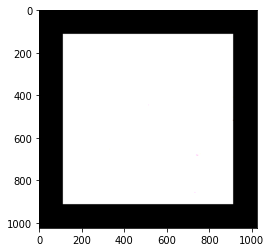

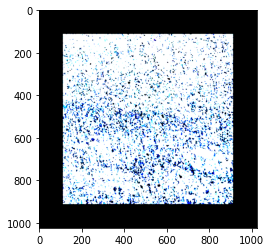

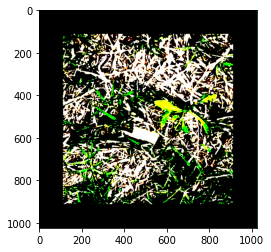

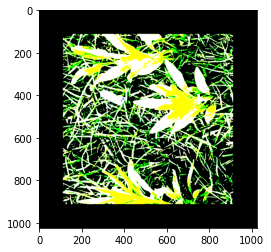

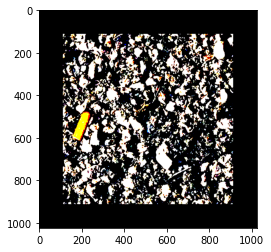

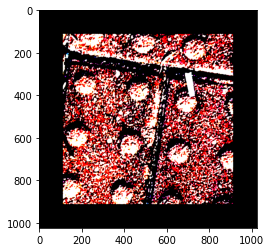

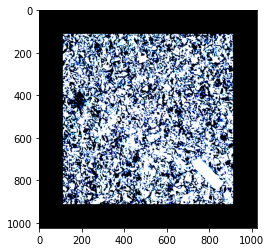

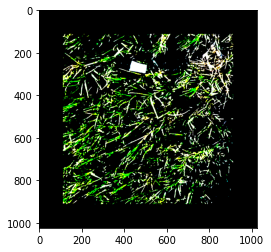

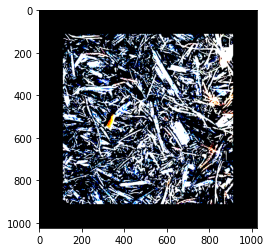

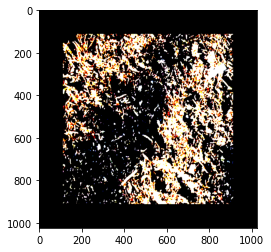

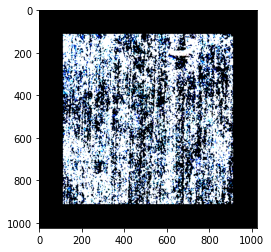

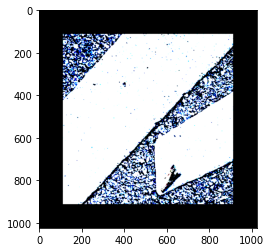

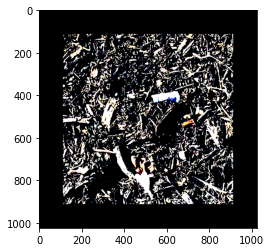

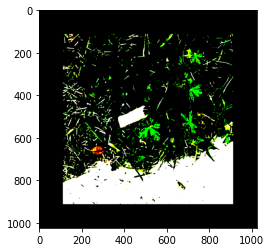

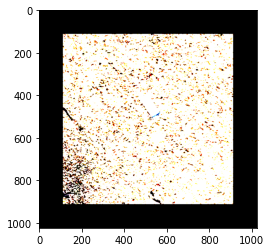

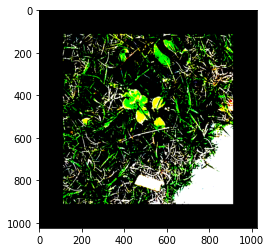

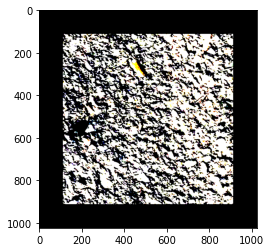

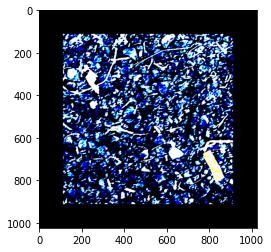

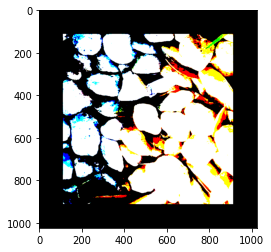

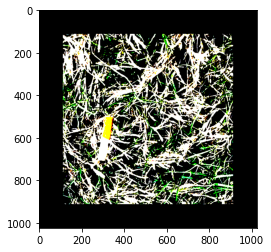

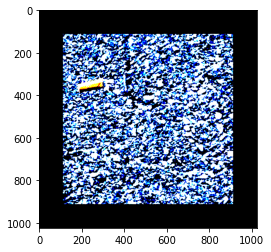

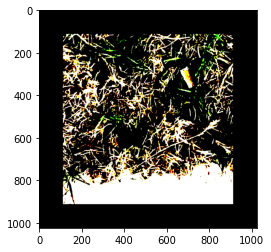

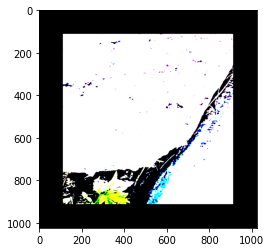

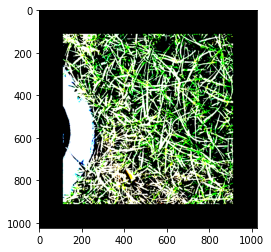

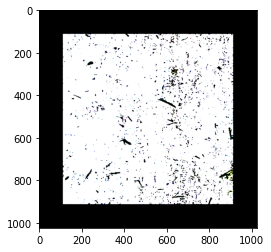

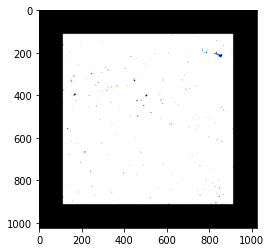

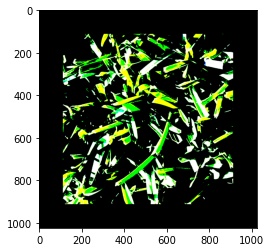

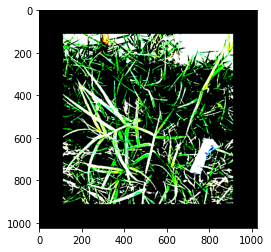

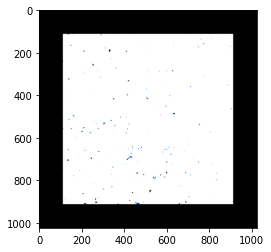

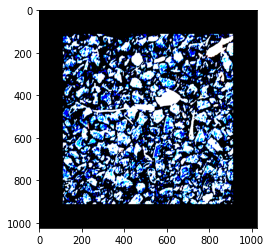

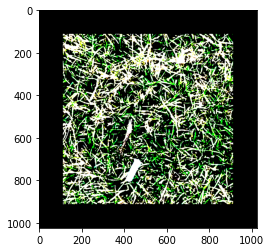

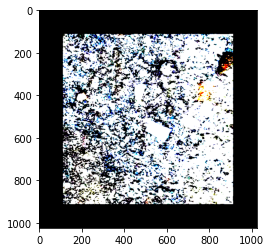

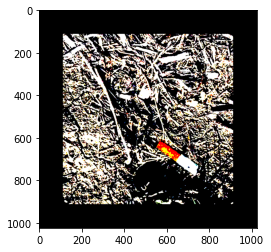

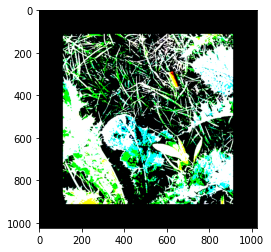

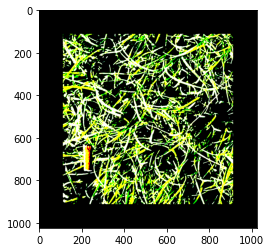

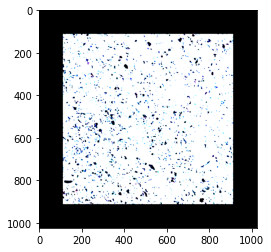

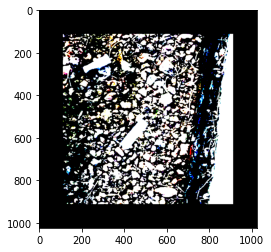

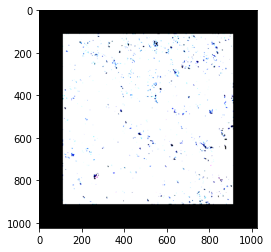

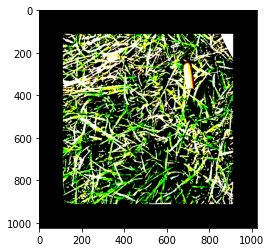

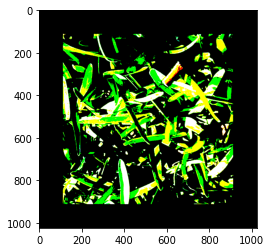

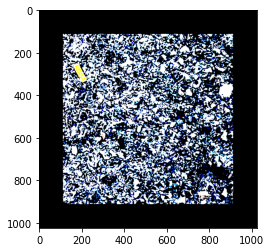

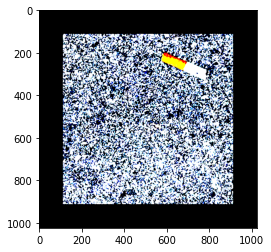

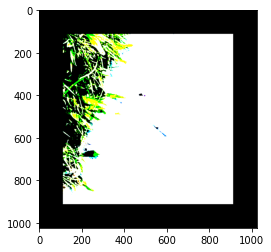

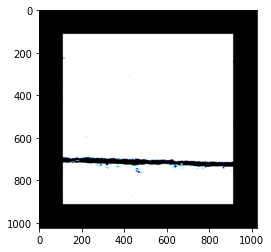

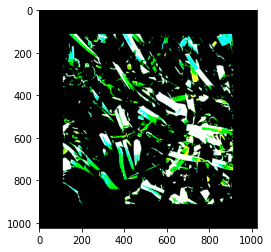

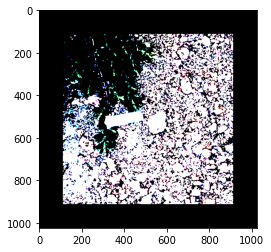

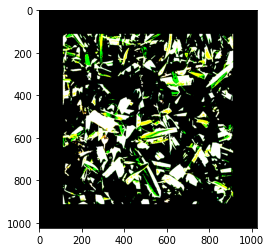

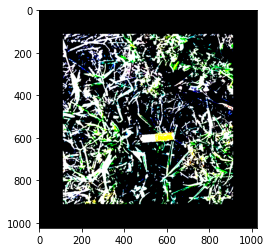

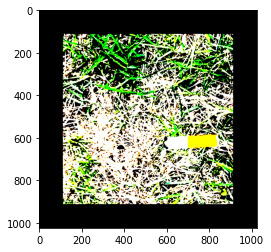

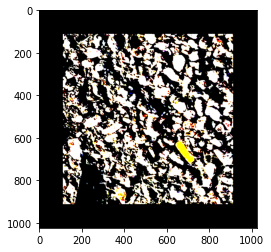

In [17]:
train_tfrecords = glob.glob('/tmp/*.tfrecord')
dataset = tf.data.TFRecordDataset(train_tfrecords)
# dataset = dataset.batch(8, drop_remainder=True)
dataset = dataset.map(_parse_function)
print(type(dataset))
for image_data in dataset.take(50):
    plt.figure()
    plt.imshow(image_data[0].numpy().reshape((1024,1024, 3)))
#     plt.imshow()
#     print(image_data)
#     continue